In [1]:
#Realizando os imports necessários
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

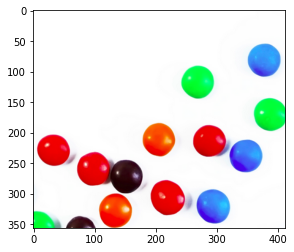

In [2]:
img_ori = cv.imread('../imagens/L&L.png')
#Convertendo cores
img_ori = cv.cvtColor(img_ori, cv.COLOR_BGR2RGB)

plt.imshow(img_ori)

In [3]:
def show_count(mask):
    '''
    Função que mostra a contagem para cada cor de L&L
    Recebe mascara desejada
    
    *** Ilustra os resultados separadamente ***
    '''
    contours, hierarchy = cv.findContours(
    mask, 
    mode=cv.RETR_EXTERNAL , 
    method=cv.CHAIN_APPROX_NONE
    )

    # Seleciona apenas os contornos com mais de 50 pixels
    contornos = []

    for contour in contours:
        if len(contour) > 50:
            contornos.append(contour)

    img_contornos = cv.drawContours(
        img_ori.copy(), 
        contornos,
        contourIdx = -1, 
        color = (127, 255, 127),
        thickness = 3
        )

    img_counts = cv.imread('../imagens/L&L.png')
    img_counts = cv.cvtColor(img_counts, cv.COLOR_BGR2RGB)
    for (i,c) in enumerate(contornos):
        M= cv.moments(c)
        cx= int(M['m10']/M['m00'])
        cy= int(M['m01']/M['m00'])
        cv.putText(img_counts, text= str(i+1), org=(cx,cy),
                fontFace= cv.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0,0,0),
                thickness=2, lineType=cv.LINE_AA)

    plt.imshow(img_counts)

In [4]:
img = cv.imread('../imagens/L&L.png')
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Definindo minimo e maximo para a cor vermelha
red_lower = np.array([133, 130, 75], np.uint8)
red_upper = np.array([255, 255, 233], np.uint8)
#Criando mascara para a cor
red_mask = cv.inRange(hsv, red_lower, red_upper)

# O processo será repetido para as demais cores utilizadas:
green_lower = np.array([60, 40, 40], np.uint8)
green_upper = np.array([70, 255, 255], np.uint8)
green_mask = cv.inRange(hsv, green_lower, green_upper)

brown_lower = np.array([50, 1, 10], np.uint8)
brown_upper = np.array([200, 115, 120], np.uint8)
brown_mask = cv.inRange(hsv, brown_lower, brown_upper)

orange_lower = np.array([10, 100, 100], np.uint8)
orange_upper = np.array([63, 255, 255], np.uint8)
orange_mask = cv.inRange(hsv, orange_lower, orange_upper)

blue_lower = np.array([100, 150, 50], np.uint8)
blue_upper = np.array([130, 255, 255], np.uint8)
blue_mask = cv.inRange(hsv, blue_lower, blue_upper)

In [5]:
#Todas as mascaras serão salvas, separadas por suas respectivas cores
masks = {}

## Tratando máscara da cor marrom

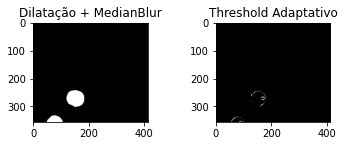

In [6]:
#REALIZA DILATAÇÃO E EROSÃO PARA MELHORAR AS IMAGENS
kernel = np.ones((13,13), np.uint8)
img_dilation_brown = cv.dilate(brown_mask, kernel, iterations=1)

#LIMPA O RUIDO DA IMAGEM
img_dilation_brown = cv.medianBlur(img_dilation_brown, 33)

plt.subplot(221)
plt.title('Dilatação + MedianBlur')
plt.imshow(img_dilation_brown, cmap="gray", vmin=0, vmax=255)

plt.subplot(222)
plt.title('Threshold Adaptativo')
plt.imshow(brown_mask, cmap="gray", vmin=0, vmax=255)

masks['Marrom'] = img_dilation_brown

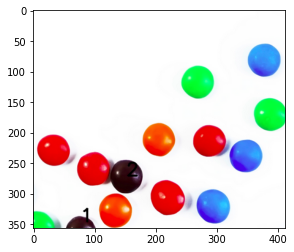

In [7]:
show_count(img_dilation_brown)

## Tratando máscara da cor laranja

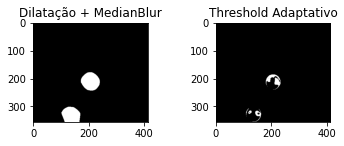

In [8]:
#REALIZA DILATAÇÃO E EROSÃO PARA MELHORAR AS IMAGENS
kernel = np.ones((3,3), np.uint8)
img_dilation_orange = cv.dilate(orange_mask, kernel, iterations=9)

#LIMPA O RUIDO DA IMAGEM
img_dilation_orange = cv.medianBlur(img_dilation_orange, 49)

plt.subplot(221)
plt.title('Dilatação + MedianBlur')
plt.imshow(img_dilation_orange, cmap="gray", vmin=0, vmax=255)

plt.subplot(222)
plt.title('Threshold Adaptativo')
plt.imshow(orange_mask, cmap="gray", vmin=0, vmax=255)

masks['Laranja'] = img_dilation_orange

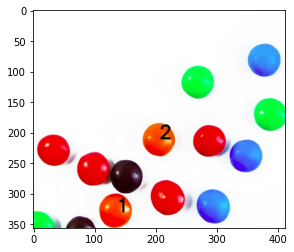

In [9]:
show_count(img_dilation_orange)

### Tratando máscara da cor vermelha

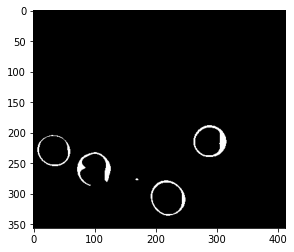

In [10]:
# Deixando contornos mais fortes
cross = cv.morphologyEx(red_mask, op=cv.MORPH_CROSS, kernel=np.ones((5,5)))

#Dilatação
red_mask = cv.morphologyEx(cross, op=cv.MORPH_DILATE, kernel=np.ones((6,6)))

# Erosão
red_mask = cv.morphologyEx(red_mask, op=cv.MORPH_ERODE, kernel=np.ones((5,5)))

# Aplicando filtro da mediana duplo
filter_median = cv.medianBlur(red_mask, 9)

filter_median2 = cv.medianBlur(filter_median, 11)
plt.imshow(filter_median2, cmap='gray')

# Aplicação de nova erosão
red_mask = cv.morphologyEx(filter_median2, op=cv.MORPH_ERODE, kernel=np.ones((3,3)), iterations=2)
plt.imshow(red_mask, cmap='gray')

masks['Vermelho'] = red_mask

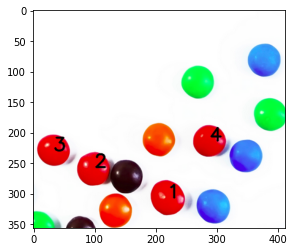

In [11]:
show_count(red_mask)

### Tratando máscara da cor azul

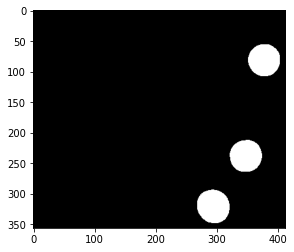

In [12]:
blue_mask = cv.morphologyEx(blue_mask,op=cv.MORPH_CLOSE, kernel=np.ones((7,7)))
plt.imshow(blue_mask, cmap='gray')

masks['Azul'] = blue_mask

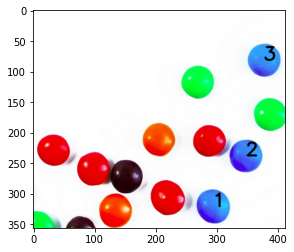

In [13]:
show_count(blue_mask)

### Tratando máscara da cor verde

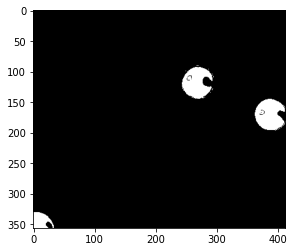

In [14]:
plt.imshow(green_mask, cmap='gray')

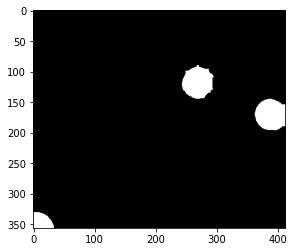

In [15]:
green_mask = cv.morphologyEx(green_mask,op=cv.MORPH_CLOSE, kernel=np.ones((13,13)))

plt.imshow(green_mask, cmap='gray')

masks['Verde'] = green_mask

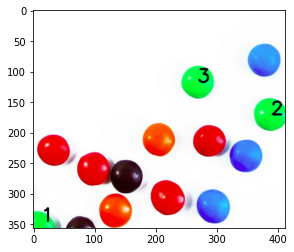

In [16]:
show_count(green_mask)

## Realizando a contagem geral
---

In [17]:
all_contours = []
count = 0
colors = {}

for color, mask in masks.items():
    contours, hierarchy = cv.findContours(
    mask, 
    mode=cv.RETR_EXTERNAL , 
    method=cv.CHAIN_APPROX_NONE
    )
        
    # Seleciona apenas os contornos com mais de 50 pixels
    count_color = 0
    for contour in contours:
        if len(contour) > 50:
            all_contours.append(contour)
            count += 1
            count_color += 1
    
    colors[color] = count_color

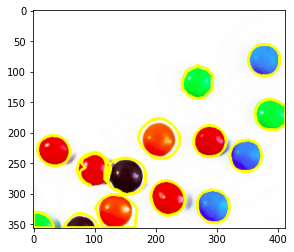

In [18]:
img_contornos = cv.drawContours(
    img_ori.copy(), 
    all_contours,
    contourIdx = -1, 
    color = (255, 255, 0),
    thickness = 3
    )

plt.imshow(img_contornos)

In [19]:
print(f'Há {count} L&L na imagem')
print(f'Sendo:')
for i, v in colors.items():
    print(f'{i}: {v}')

Há 14 L&L na imagem
Sendo:
Marrom: 2
Laranja: 2
Vermelho: 4
Azul: 3
Verde: 3


## Verificando tamanhos dos L&Ls

In [20]:
# Como não foi definida métrica para o tamnho dos L&Ls 
# será utilizada a mediana do total de contornos achados
len_contours = []

for contour in all_contours:
    len_contours.append(len(contour))
    
median = np.median(len_contours)
median

156.0

In [21]:
# Foi definido um limite de 10% acima ou abaixo da mediana para ser considerado um defeito
max_lim = median + (median * 0.1)
min_lim = median - (median * 0.1)

defectives = 0

for contour in len_contours:
    if contour > max_lim:
        defectives += 1
    elif contour < min_lim:
        defectives += 1

In [22]:
print(f'Nesta imagem são vistos {defectives} L&Ls com problemas')

Nesta imagem são vistos 6 L&Ls com problemas


- No inicio deste projeto achamos que seria fácil realizar a binariazação das bolinhas dado que o fundo era totalmente diferente das cores das bolinhas, porém, ao iniciar, percebemos o problema das sombras e elementos muito próximos;

- Foi incrível realizar o projeto e ver os resultados, tivemos que procurar novos conhecimentos o que é sempre bom para colocarmos na nossa "caixa de ferramentas";

- Grupo: *Gabriel Huzian, Jessica Andreotti e Vinicius Lande.*